In [194]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("./deconvoluted.mplstyle")

image_under = cv2.imread("../data/hdr/hdr_test_-2.jpg")
image_middle = cv2.imread("../data/hdr/hdr_test_0.jpg")
image_over = cv2.imread("../data/hdr/hdr_test_+2.jpg")

In [195]:
assert image_under.shape == image_middle.shape == image_over.shape

In [196]:
image_under.dtype

dtype('uint8')

3 bracketed shots 2 EV apart at f/10

Shutter speeds are:
- -2: 1/500
- 0: 1/125
- +2: 1/40 (125 ISO?)

In [197]:
images = [image_under, image_middle, image_over]

# crop images to 5/4 ratio
long_side = max(image_middle.shape[:2])
short_side = min(image_middle.shape[:2])
for i in range(len(images)):
    start_long = long_side - (5*(short_side//4))
    images[i] = images[i][start_long:long_side, 0:short_side]

# shutter speeds used
exposure_times = np.array([1/500, 1/125, 1/40], dtype=np.float32) 

In [198]:

merge_debevec = cv2.createMergeDebevec()
hdr = merge_debevec.process(images, times=exposure_times.copy())

In [199]:
tonemap = cv2.createTonemapReinhard(gamma=1.9, intensity=0, light_adapt=0, color_adapt=0)
ldr = tonemap.process(hdr)
ldr_8bit = np.clip(ldr * 255, 0, 255).astype(np.uint8)

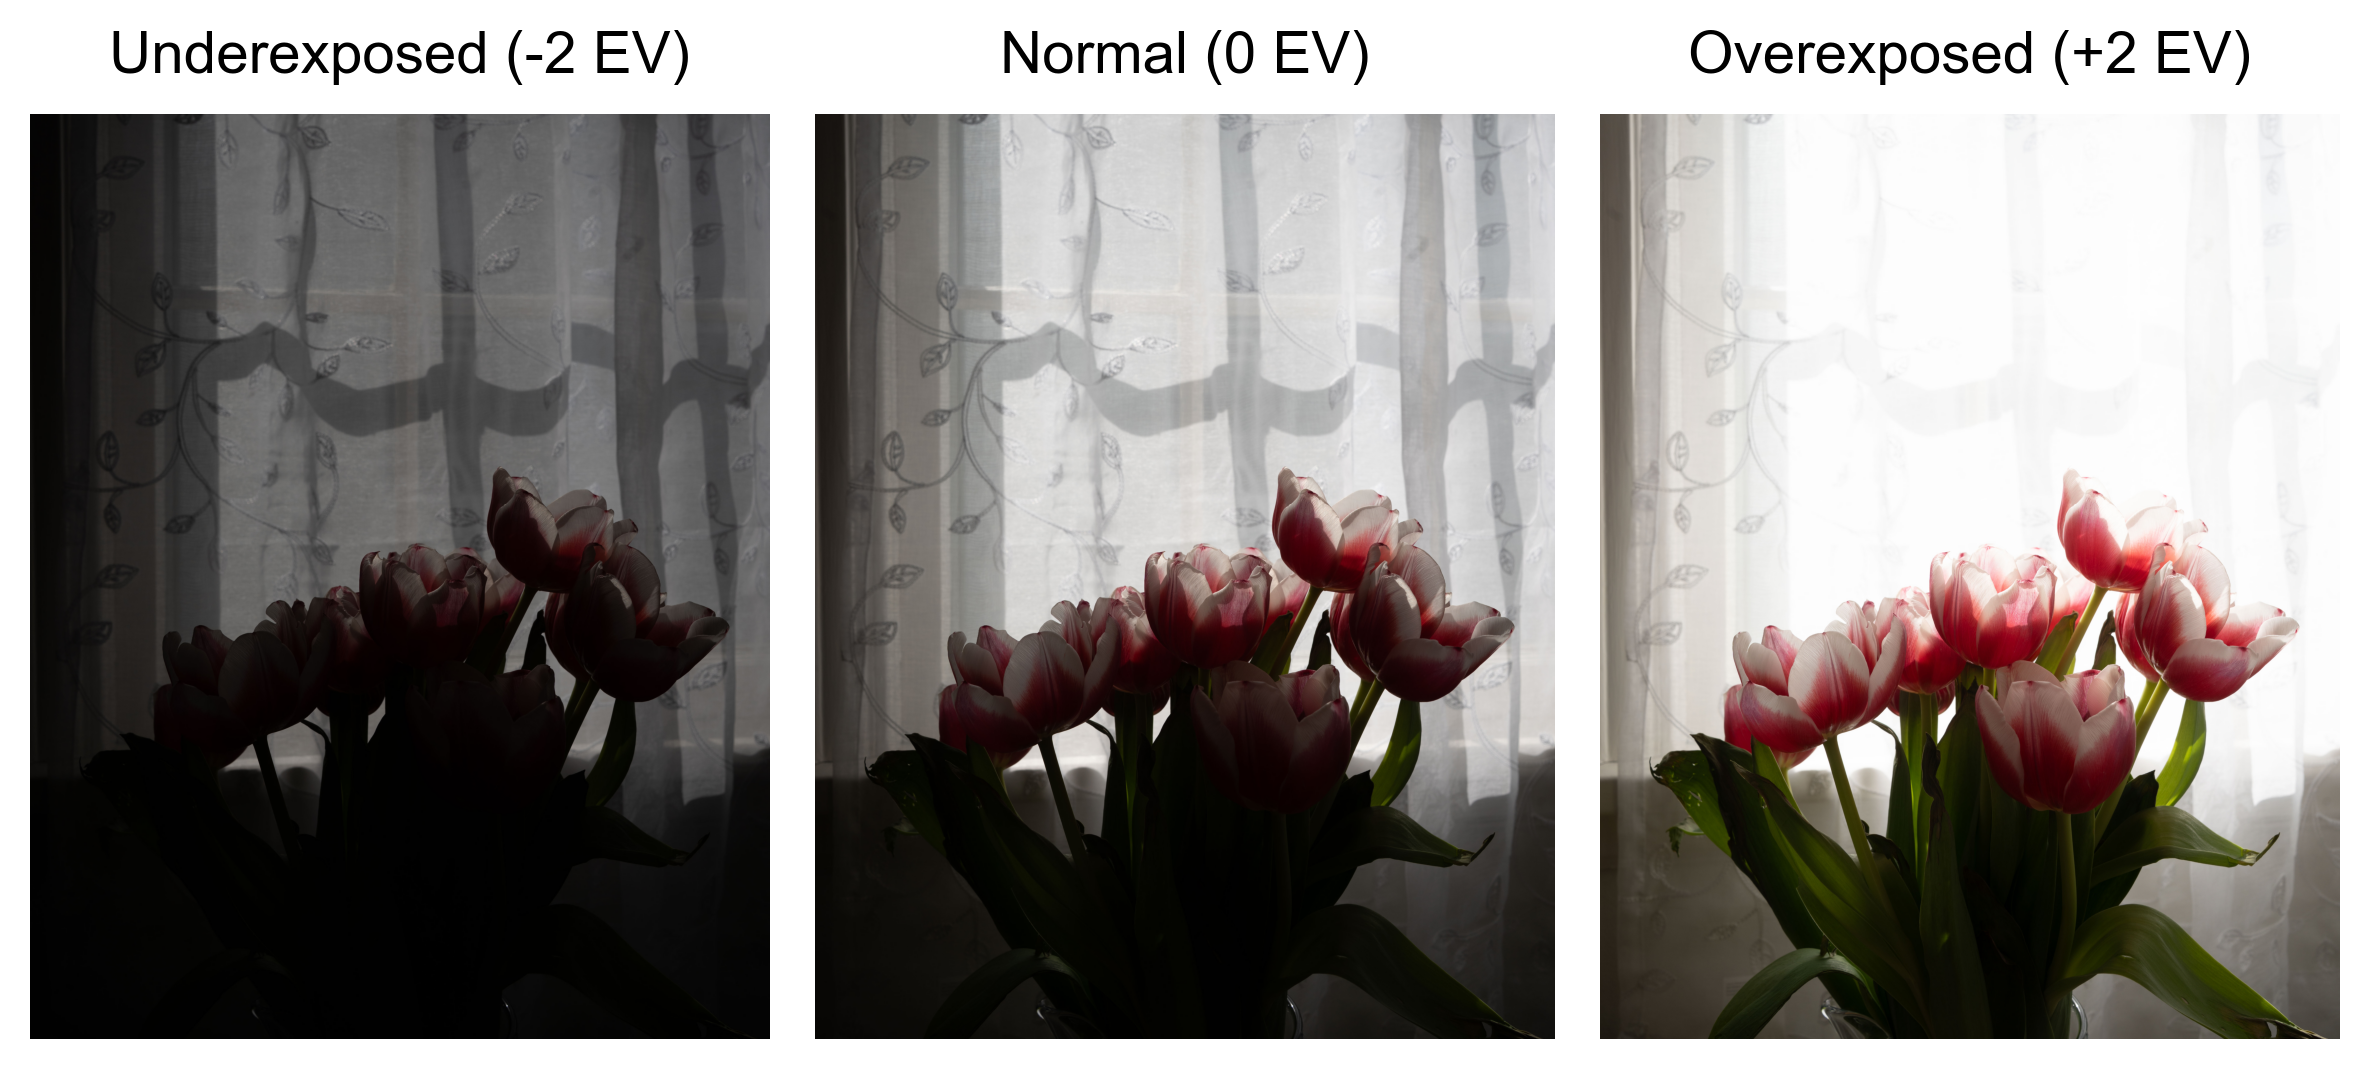

In [200]:
fig, axes = plt.subplots(1, 3)
titles = ["Underexposed (-2 EV)", "Normal (0 EV)", "Overexposed (+2 EV)"]

for ax, img, title in zip(axes, images, titles):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")  # Hide axes

# fig.suptitle("HDR Sequence")
plt.show()

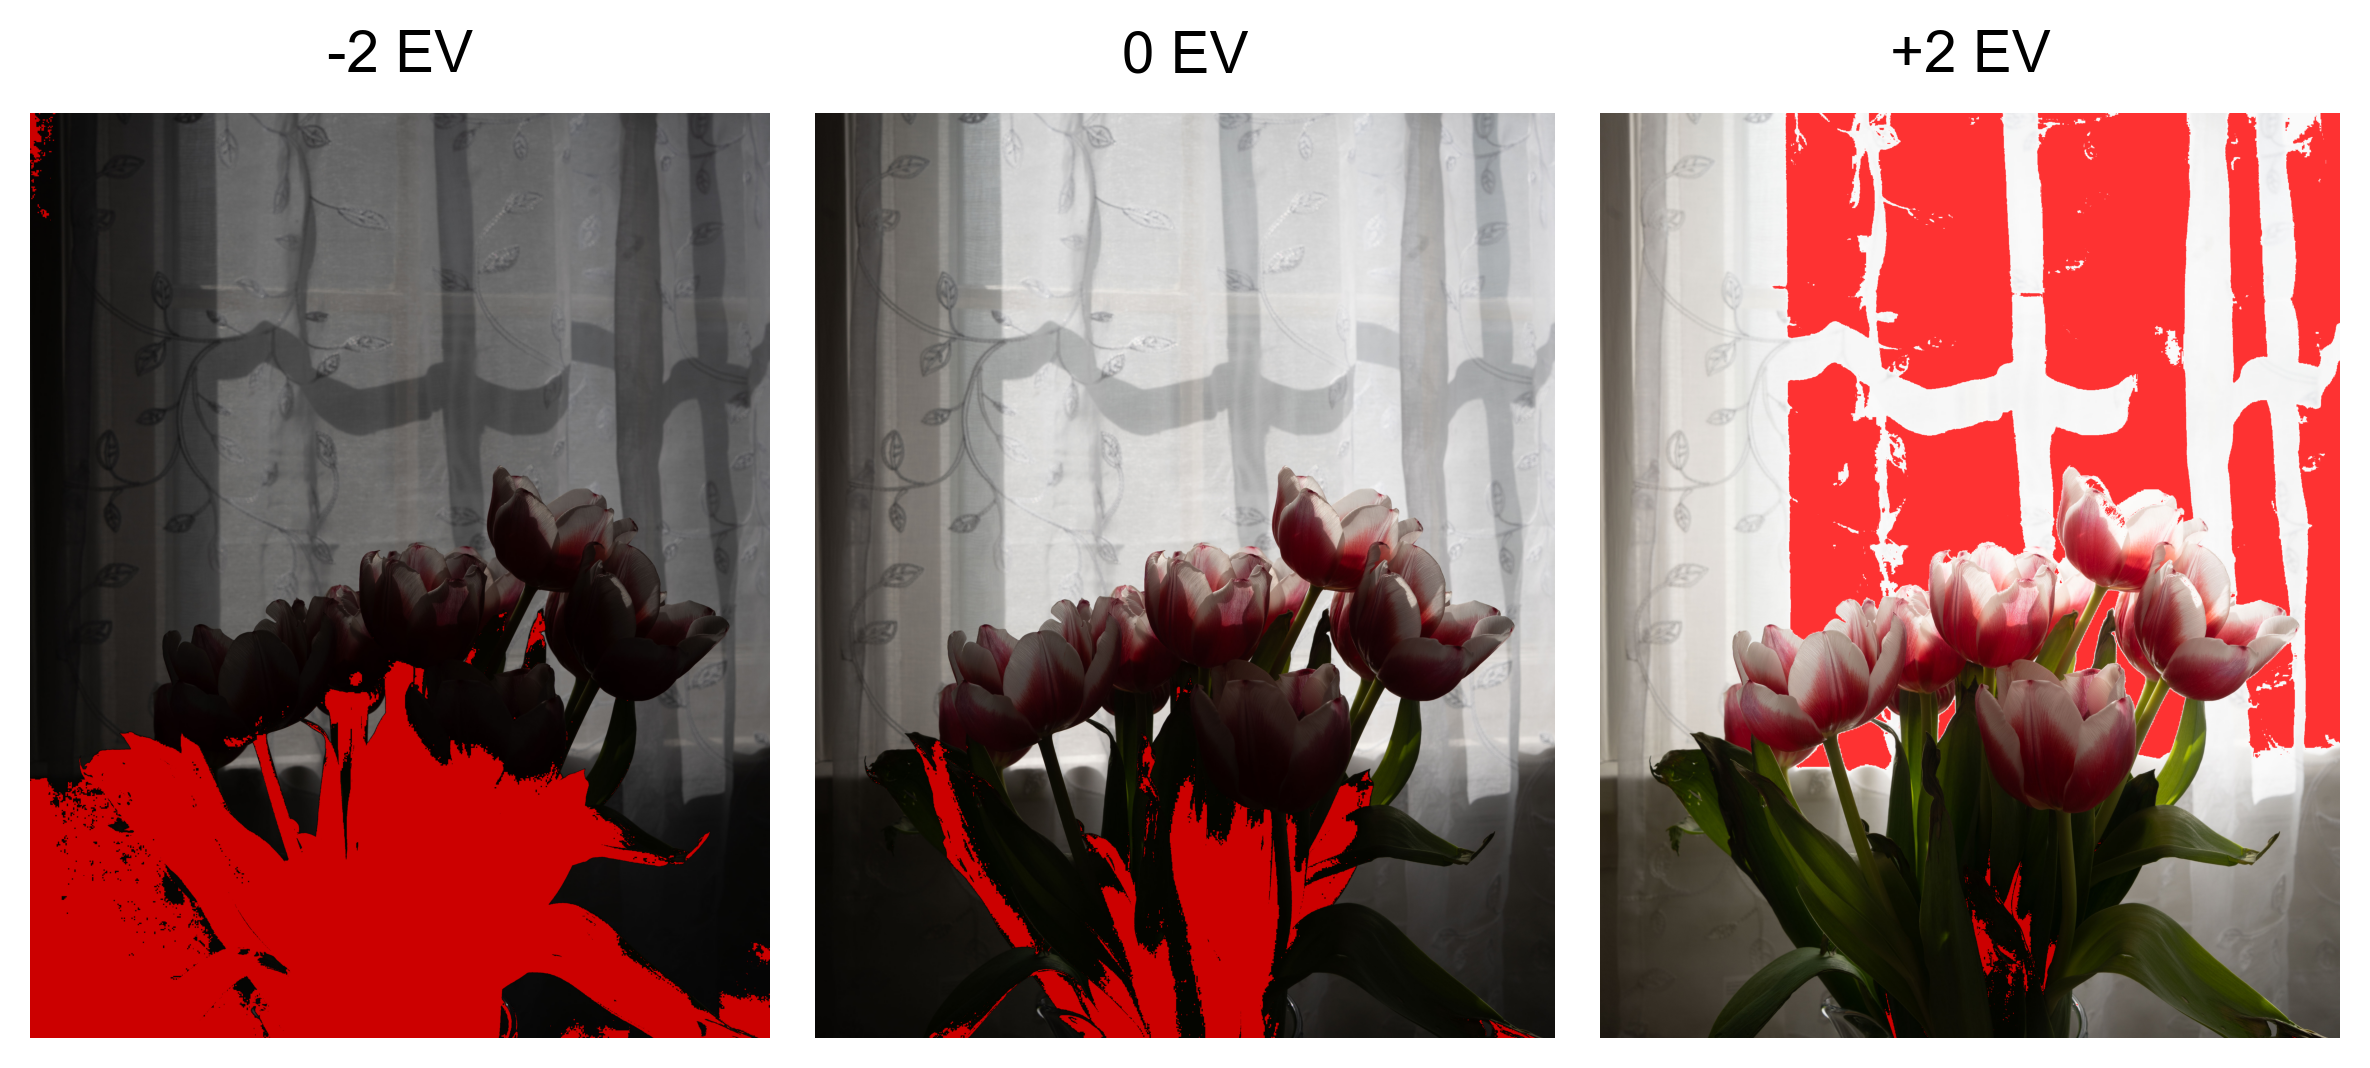

In [201]:
fig, axes = plt.subplots(1, 3)
titles = ["-2 EV", "0 EV", "+2 EV"]

def highlight_clipped(img, ax, title):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = (img >= 251).all(axis=2) | (img <= 4).all(axis=2)

    overlay = img_rgb.copy()
    overlay[mask] = [255, 0, 0]

    # alpha blending
    alpha = 0.8
    blended = img_rgb.copy()
    blended[mask] = (1 - alpha) * img_rgb[mask] + alpha * overlay[mask]

    ax.imshow(blended)
    ax.set_title(title)
    ax.axis("off")

# Apply function to all three images
for ax, img, title in zip(axes, images, titles):
    highlight_clipped(img, ax, title)
    
# fig.suptitle("HDR Sequence, with Clipped Regions Highlighted", fontsize=18)
plt.show()

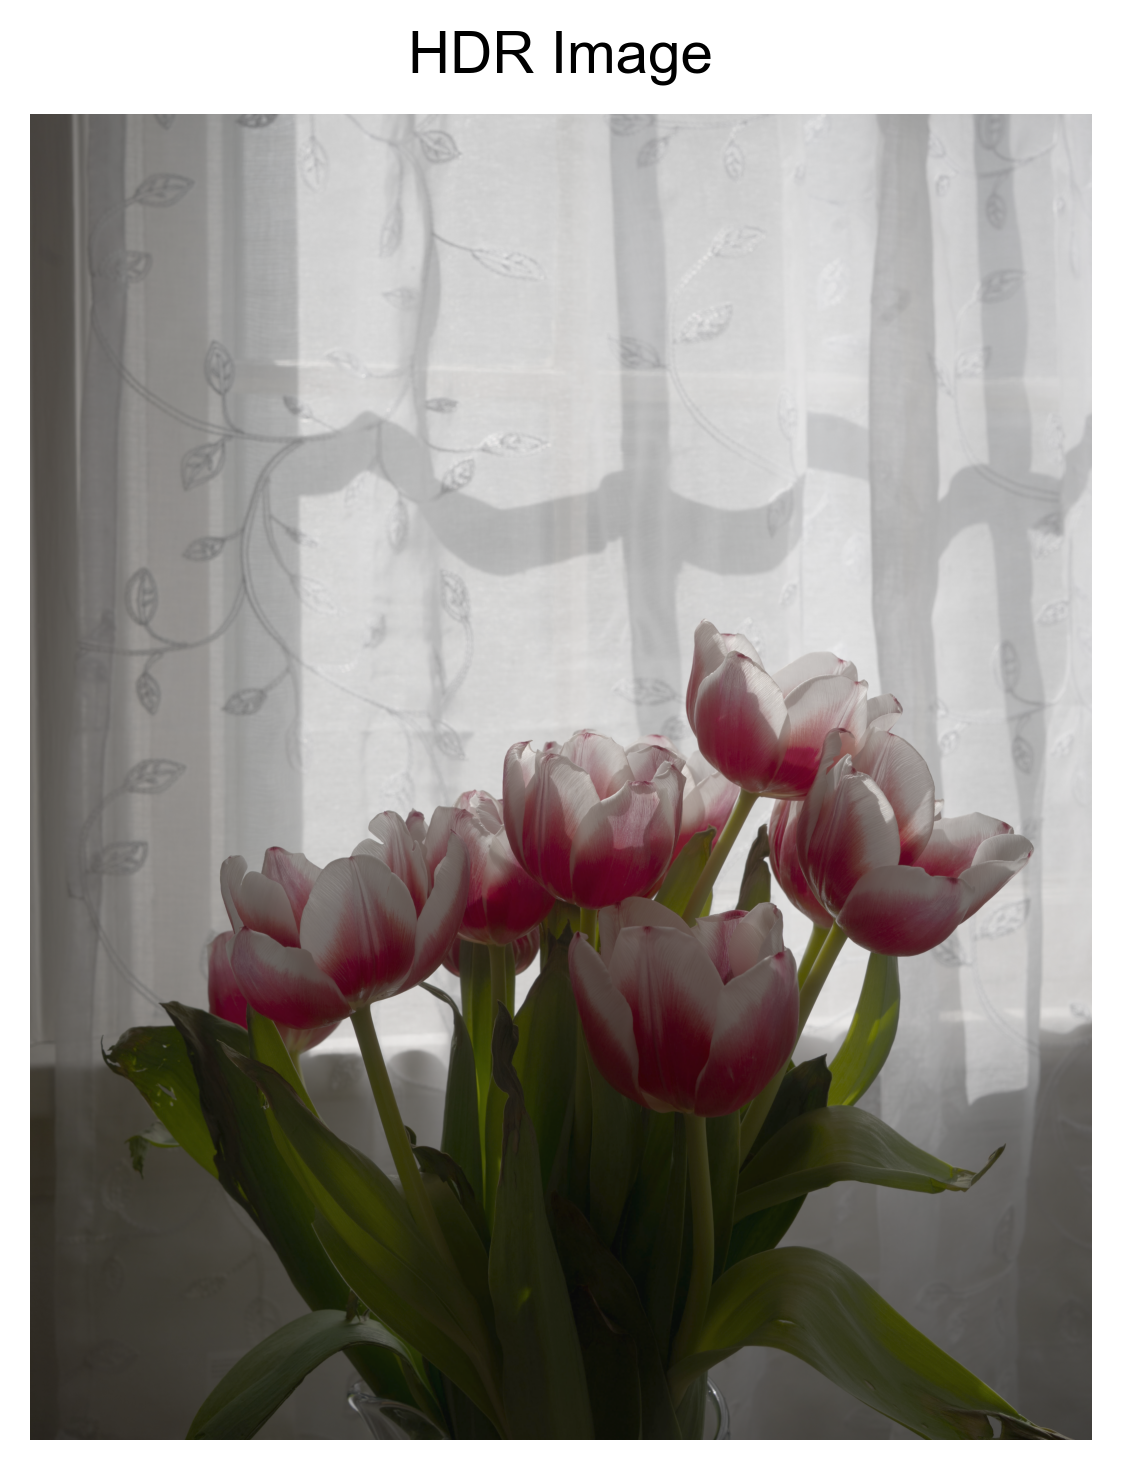

In [202]:
ldr_8bit_rgb = cv2.cvtColor(ldr_8bit, cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(10, 6))
plt.imshow(ldr_8bit_rgb)
plt.axis("off")
plt.title("HDR Image")
plt.show()

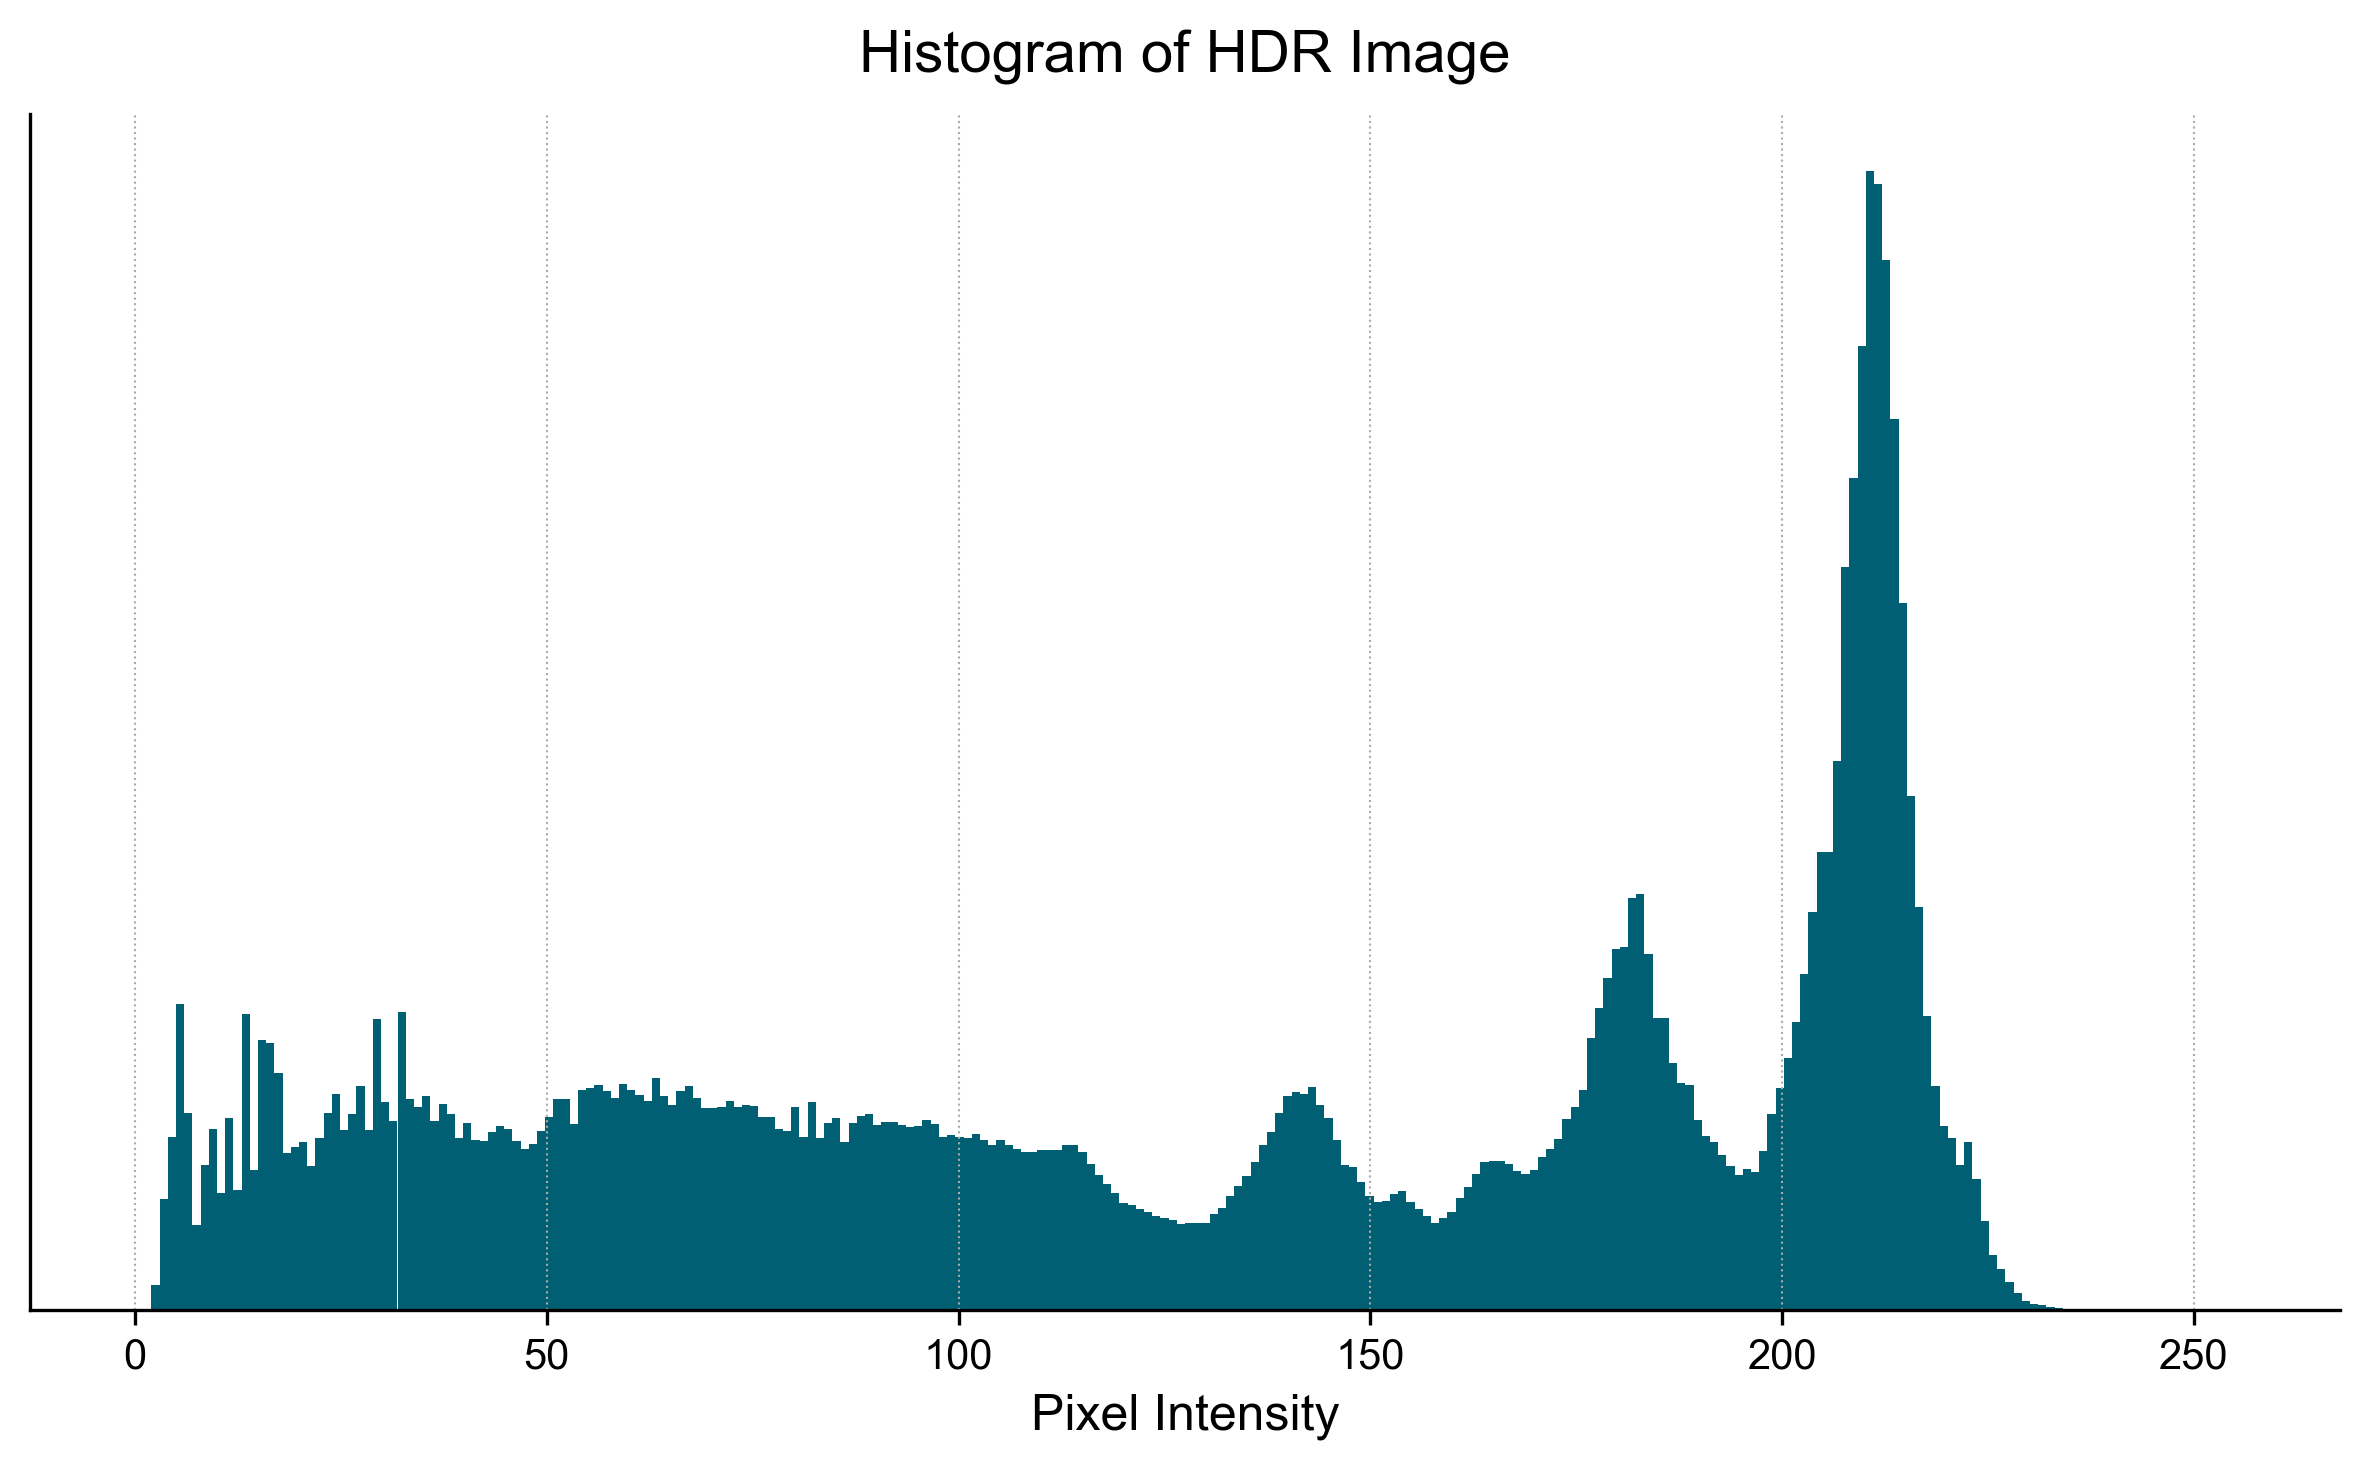

In [203]:
# plt.figure(figsize=(10, 6))
plt.hist(ldr_8bit_rgb.ravel(), bins=256) 
plt.yticks([])
plt.title("Histogram of HDR Image")
plt.xlabel("Pixel Intensity")
plt.show()